In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go

from odf.opendocument import load as odf_load

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation


In [4]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`


In [5]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


### Plot of autocorrelation function

In [6]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


### Get ANOVA table

In [7]:
def get_ANOVA_table(df, n_vars=2):
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]
  
  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars)

  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  meanY = data_struct[:, 0].mean()
  
  SST = ((data_struct[:, 0] - meanY)**2).sum()
  SSR = ((hat_Y - meanY)**2).sum()
  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a survival function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR / SST

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])
  
  print(f"Analyis of Variance")
  display(anova_table)


  return anova_table, [SST, SSR, SSE] 

### Get multiple regression coefficients

In [8]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [9]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, is_reg_diff=False):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  # -- print Durbin-Watson statistics
  print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "corr_matrix": corr_matrix, 
    "R_sq": R_sq, "dw_stats": dw_stats}


### Perform Durbin-Watson Test

In [10]:
def test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl_arr):
  for significance_lvl in significance_lvl_arr:
    if abs(significance_lvl - 0.05) < 1e-4:
      d_lower = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")
      
    elif abs(significance_lvl - 0.01) < 1e-4:
      d_lower = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")

    test_status = "" 
    if dw_stats > d_upper:
      test_status = "null hypothesis accepted"
    elif dw_stats < d_lower:
      test_status = "null hypotesis rejected"
    else:
      test_status = "inconclusive"

    print(f"significance_lvl: {significance_lvl}")
    print(f"  durbin-watson statistics: {dw_stats:.2f}")
    print(f"  durbin-watson critical values (d_L, d_U): {d_lower, d_upper}")
    print(f"  conclusion: {test_status}\n")

### Durbin-Watson critical value

In [11]:
df_dw_crit_05 = pd.read_excel("durbin-watson-test-bounds-alpha-0_05.ods",
  header=[1, 2], index_col=0)
df_dw_crit_01 = pd.read_excel("durbin-watson-test-bounds-alpha-0_01.ods", 
  header=[1, 2], index_col=0)

## Load the data

### Sales and income data

In [12]:
filename = "listrik.ods"

df = read_ods(filename)
df["Tahun"].astype('str')
df["ln Y_t"] = np.log(df["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)"])
df["ln X_t"] = np.log(df["Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"])

df["diff ln Y_t"] = df["ln Y_t"] - df["ln Y_t"].shift(1)
df["diff ln X_t"] = df["ln X_t"] - df["ln X_t"].shift(1)

df

,Tahun,Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW),Listrik Yang Didistribusikan Kepada Pelanggan (GWh),ln Y_t,ln X_t,diff ln Y_t,diff ln X_t
0,2001,20850.00,79169.63,9.945109,11.279348,NaN,NaN
1,2002,21052.00,84500.80,9.954751,11.344516,0.009642,0.065168
2,2003,21113.00,88411.85,9.957644,11.389761,0.002893,0.045245
3,2004,21206.00,90440.18,9.962039,11.412444,0.004395,0.022683
4,2005,21459.00,99827.50,9.973899,11.511199,0.011860,0.098755
5,2006,22515.00,107032.30,10.021937,11.580886,0.048038,0.069687
6,2007,22531.00,112609.85,10.022647,11.631684,0.000710,0.050799
7,2008,22153.30,121246.84,10.005742,11.705584,-0.016906,0.073899
8,2009,25986.90,129018.85,10.165348,11.767714,0.159606,0.062130
9,2010,25609.60,134193.15,10.150723,11.807035,-0.014625,0.039322


In [13]:
num_of_rk = 10
df_acorr_analysis = get_correlogram(df, num_of_rk, columns=["Tahun", "Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.878268,3.927732,17.862937,-0.468014,0.468014
1,2,0.729098,2.044809,30.857219,-0.746290,0.746290
2,3,0.573655,1.351015,39.374572,-0.888719,0.888719
3,4,0.418338,0.906007,44.187249,-0.966428,0.966428
4,5,0.283235,0.589686,46.540427,-1.005311,1.005311
5,6,0.145837,0.298482,47.208862,-1.022640,1.022640
6,7,0.012405,0.025276,47.214070,-1.027185,1.027185
7,8,-0.103931,-0.211766,47.610130,-1.027218,1.027218
8,9,-0.201157,-0.408954,49.228692,-1.029519,1.029519
9,10,-0.288000,-0.580672,52.878230,-1.038092,1.038092


C:\Users\User\AppData\Local\Temp\ipykernel_18336\2725728046.py:13: MatplotlibDeprecationWarning: MarkerStyle(None) is deprecated since 3.6; support will be removed two minor releases later.  Use MarkerStyle('') to construct an empty MarkerStyle.
  stem_handler[0].set_marker(None)


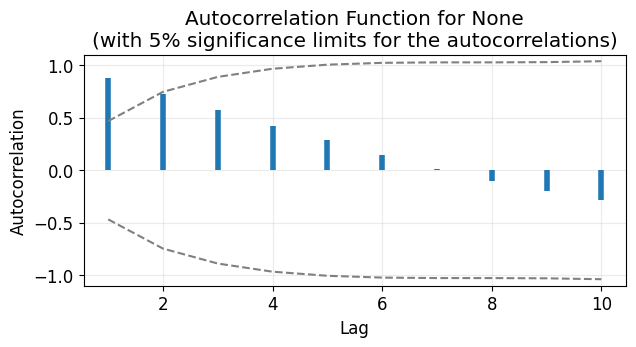

In [14]:
plot_autocorr_func(df_acorr_analysis)

In [15]:
num_of_rk = 10
df_acorr_analysis2 = get_correlogram(df, num_of_rk, columns=["Tahun", "Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)"])
df_acorr_analysis2

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.881017,3.940026,17.974934,-0.468014,0.468014
1,2,0.748932,2.096449,31.685784,-0.747708,0.747708
2,3,0.584606,1.363950,40.531456,-0.897097,0.897097
3,4,0.431827,0.925114,45.659499,-0.976986,0.976986
4,5,0.273227,0.561795,47.849315,-1.017935,1.017935
5,6,0.110965,0.224643,48.236302,-1.033873,1.033873
6,7,-0.025935,-0.052373,48.259069,-1.036479,1.036479
7,8,-0.173037,-0.349376,49.356932,-1.036621,1.036621
8,9,-0.267619,-0.537077,52.221731,-1.042929,1.042929
9,10,-0.355869,-0.704101,57.794015,-1.057863,1.057863


C:\Users\User\AppData\Local\Temp\ipykernel_18336\2725728046.py:13: MatplotlibDeprecationWarning: MarkerStyle(None) is deprecated since 3.6; support will be removed two minor releases later.  Use MarkerStyle('') to construct an empty MarkerStyle.
  stem_handler[0].set_marker(None)


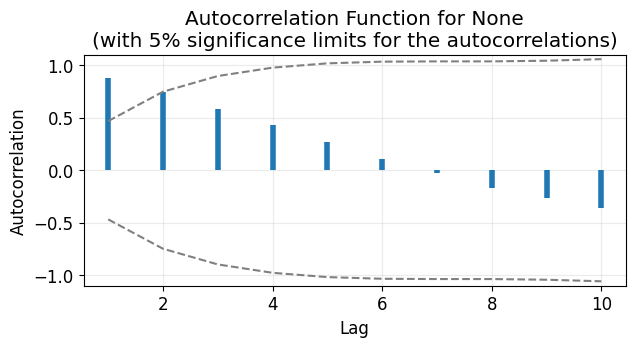

In [16]:
plot_autocorr_func(df_acorr_analysis2)

### Plot Data

In [17]:
df["Tahun"] = df["Tahun"].astype(str)
df["Tahun"]

0     2001
1     2002
2     2003
3     2004
4     2005
5     2006
6     2007
7     2008
8     2009
9     2010
10    2011
11    2012
12    2013
13    2014
14    2015
15    2016
16    2017
17    2018
18    2019
19    2020
Name: Tahun, dtype: object

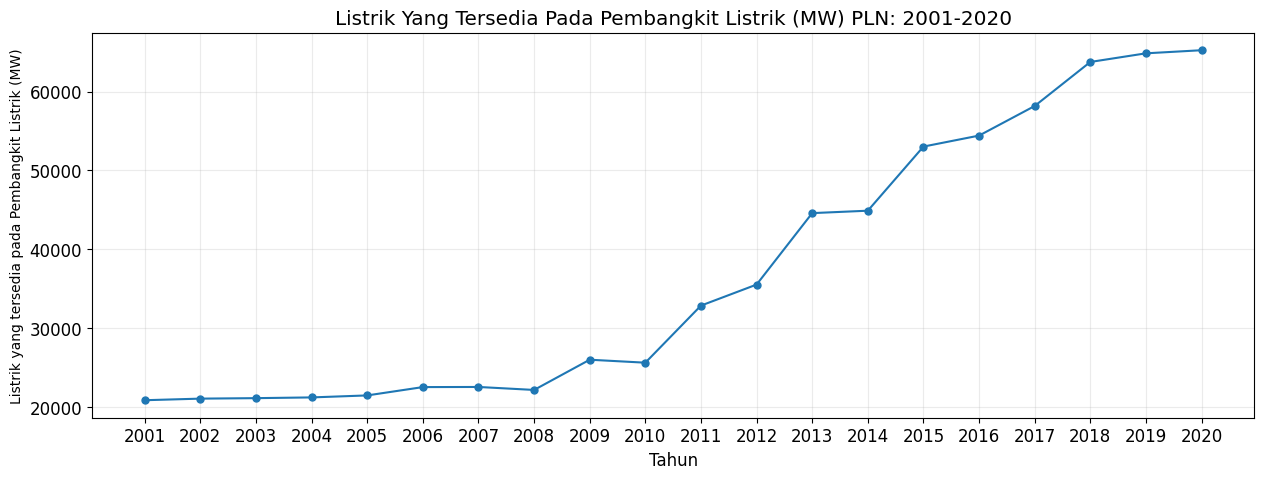

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df["Tahun"], df["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)"], marker='o', markersize=5)
ax.set_xlabel("Tahun")
ax.set_ylabel("Listrik yang tersedia pada Pembangkit Listrik (MW)", fontsize=10)
ax.set_title("Listrik Yang Tersedia Pada Pembangkit Listrik (MW) PLN: 2001-2020")
ax.grid("on")
plt.show(fig)


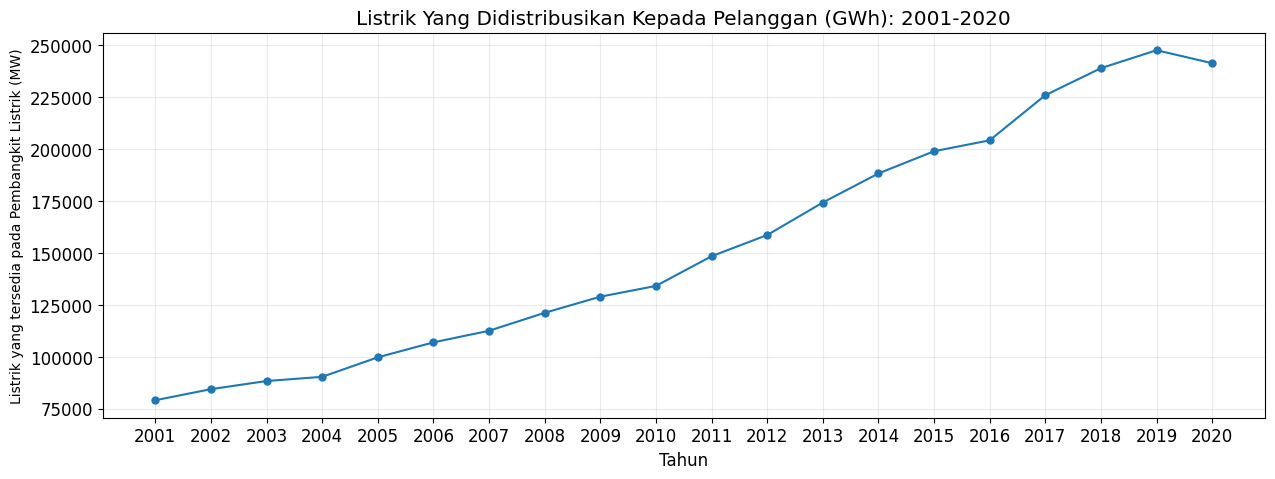

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df["Tahun"],df["Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"], marker='o', markersize=5)
ax.set_xlabel("Tahun")
ax.set_ylabel("Listrik yang tersedia pada Pembangkit Listrik (MW)", fontsize=10)
ax.set_title("Listrik Yang Didistribusikan Kepada Pelanggan (GWh): 2001-2020")
ax.grid("on")
plt.show(fig)


### standardized residual Leverage for regression

In [20]:
df_select = df[["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)", "Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"]]
df_select = df_select.dropna()
df_select = df_select.reset_index(drop=True)

num_of_samples = 118     # (Sharpe, 2021) Table 19.6
df_select = df_select.iloc[:num_of_samples]

In [21]:
df_minitab = df_select.copy()
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

header: ['Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)', 'Listrik Yang Didistribusikan Kepada Pelanggan (GWh)']


In [22]:
column_name = ["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)", "Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False)


Regression Analysis: Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW) versus Listrik Yang Didistribusikan Kepada Pelanggan (GWh)
The regression equation is
Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW) = -7944.141 + 0.293 Listrik Yang Didistribusikan Kepada Pelanggan (GWh)


Predictor,Coef,SE Coef,t-score,p-value
Constant,-7944.1411,2162.5714,-3.67,0.0017
Listrik Yang Didistribusikan Kepada Pelanggan (GWh),0.2930,0.0132,22.16,0.0000


s_yxs = 3311.4798   R_sq = 96.5%   R-sq(adj) = 96.3%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,5385988455.0727,5385988455.0727,491.158,0.0000
Residual error,18,197386166.7713,10965898.1540,,
Total,19,5583374621.8440,,,


Durbin-Watson Statistics = 0.58


In [23]:
df_minitab

,Y,X_1,hat_Y
0,20850.00,79169.63,15252.674929
1,21052.00,84500.80,16814.715447
2,21113.00,88411.85,17960.658752
3,21206.00,90440.18,18554.962374
4,21459.00,99827.50,21305.460706
5,22515.00,107032.30,23416.477523
6,22531.00,112609.85,25050.707737
7,22153.30,121246.84,27581.358294
8,25986.90,129018.85,29858.568461
9,25609.60,134193.15,31374.645842


In [24]:
df_minitab

,Y,X_1,hat_Y
0,20850.00,79169.63,15252.674929
1,21052.00,84500.80,16814.715447
2,21113.00,88411.85,17960.658752
3,21206.00,90440.18,18554.962374
4,21459.00,99827.50,21305.460706
5,22515.00,107032.30,23416.477523
6,22531.00,112609.85,25050.707737
7,22153.30,121246.84,27581.358294
8,25986.90,129018.85,29858.568461
9,25609.60,134193.15,31374.645842


In [25]:
def get_accuracy_measures(dataframe):
  Y_t = dataframe["Y"]
  hat_Y_t = dataframe["hat_Y"]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSE = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSE

  

In [26]:
MAPE, MAD, MSE = get_accuracy_measures(df_minitab)
print(f"MAPE   {MAPE*100:8.2f}%")
print(f"MAD    {MAD:8.2f}")
print(f"MSE    {MSE:8.2f}")

MAPE       9.70%
MAD     2670.72
MSE    9869308.34


In [27]:
def get_leverage(df):
  columns = df.columns[1:]
  # print(columns)
  n_vars = len(columns)
  n_samples = len(df)

  X_arr = np.ones([n_samples, 1+n_vars])
  for i, predictor in enumerate(columns):
    X_arr[:, i+1] = df[predictor]

  cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  # print(cofactor_matrix)

  leverage_arr = np.zeros(n_samples)
  for i in range(n_samples):
    vec_x_i = X_arr[i, :]
    leverage_arr[i] = vec_x_i.dot(cofactor_matrix).dot(vec_x_i.transpose())

  return leverage_arr



In [28]:
df_stdzed_residual = df_select.copy()
from_column_names = df_stdzed_residual.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]

df_stdzed_residual = df_stdzed_residual.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

print(f"new header: {df_stdzed_residual.columns.to_list()}")

header: ['Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)', 'Listrik Yang Didistribusikan Kepada Pelanggan (GWh)']
new header: ['Y', 'X_1']


In [29]:
df_stdzed_residual

,Y,X_1
0,20850.00,79169.63
1,21052.00,84500.80
2,21113.00,88411.85
3,21206.00,90440.18
4,21459.00,99827.50
5,22515.00,107032.30
6,22531.00,112609.85
7,22153.30,121246.84
8,25986.90,129018.85
9,25609.60,134193.15


In [30]:
leverage_arr = get_leverage(df_stdzed_residual)

### Histogram of leverage values

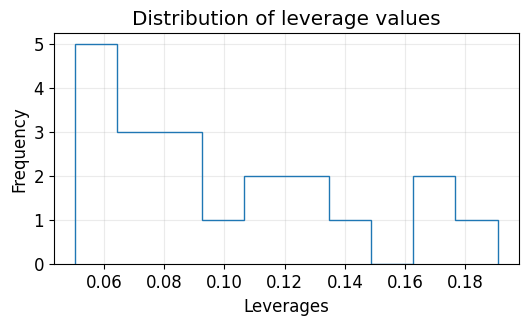

In [31]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.hist(leverage_arr, histtype="step")
ax.set_xlabel("Leverages")
ax.set_ylabel("Frequency")
ax.set_title(f"Distribution of leverage values")
ax.grid("on")

plt.show(fig)

### Plot of outliers based on large leverage values

In [32]:
n_vars = len(df_stdzed_residual.columns[1:])
n_samples = len(df_stdzed_residual)
l_bound_leverage = 1.4*(n_vars + 1) / n_samples
is_outlier = leverage_arr > l_bound_leverage

In [33]:
l_bound_leverage

0.13999999999999999

In [34]:
leverage_arr

array([0.13850569, 0.12629459, 0.11791245, 0.11375736, 0.09623533,
       0.08469255, 0.07689318, 0.06677254, 0.05969824, 0.05605621,
       0.05043092, 0.05039999, 0.0568012 , 0.06914497, 0.08277082,
       0.09080195, 0.13338621, 0.16604937, 0.19074497, 0.17265146])

In [35]:
is_outlier

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True])

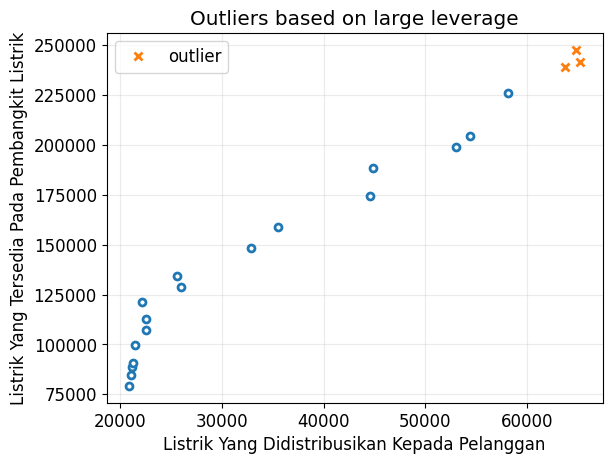

In [36]:
fig, ax = plt.subplots()

height_data = df_stdzed_residual["Y"]
drop_data = df_stdzed_residual["X_1"]

normal_height_data = height_data[np.logical_not(is_outlier)]
normal_drop_data = drop_data[np.logical_not(is_outlier)]

outlier_height_data = height_data[is_outlier]
outlier_drop_data = drop_data[is_outlier]

ax.plot(normal_height_data, normal_drop_data,
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

ax.plot(outlier_height_data, outlier_drop_data,
  marker='x', markersize=6, linestyle="None",
  markeredgewidth=2, label="outlier")


ax.set_xlabel("Listrik Yang Didistribusikan Kepada Pelanggan")
ax.set_ylabel("Listrik Yang Tersedia Pada Pembangkit Listrik")
ax.set_title("Outliers based on large leverage")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

### standardized residual $e_i/s_{e_i}$

In [37]:
df_regress = df_minitab.copy()
Y_data = df_regress['Y']
hat_Y_data = df_regress["hat_Y"]
e_arr = (hat_Y_data - Y_data).to_numpy()
n_samples = len(Y_data)
n_vars = len(df_stdzed_residual.columns)
sumSq_Y_hat_Y = ((Y_data - hat_Y_data)**2).sum()
s_yxs = np.sqrt(sumSq_Y_hat_Y/(n_samples - n_vars - 1))

stdzed_residual_arr = e_arr/(s_yxs * np.sqrt(1 - leverage_arr))

is_large_stdzed_residual = np.abs(stdzed_residual_arr) > 2.

### Unusual observation

In [38]:
df_observation = df_select.copy()
df_observation["FitJumlah"] = df_regress["hat_Y"]
df_observation["Residual"] = df_regress["Y"] - df_regress["hat_Y"]
df_observation["StdzedResid"] = stdzed_residual_arr

# -- get unusua observation status
status_arr = []
for stat_leverage, stat_stdzed_resid in zip(is_outlier, is_large_stdzed_residual):
  status = '' 
  if stat_leverage:
    status += 'X' 

  if stat_stdzed_resid and status == 'X':
    status += ",R"
  if stat_stdzed_resid and status == '':
    status += 'R'

  status_arr.append(status)

df_observation["Observe"] = status_arr 

df_observation

,Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW),Listrik Yang Didistribusikan Kepada Pelanggan (GWh),FitJumlah,Residual,StdzedResid,Observe
0,20850.00,79169.63,15252.674929,5597.325071,-1.769785,
1,21052.00,84500.80,16814.715447,4237.284553,-1.330366,
2,21113.00,88411.85,17960.658752,3152.341248,-0.985016,
3,21206.00,90440.18,18554.962374,2651.037626,-0.826429,
4,21459.00,99827.50,21305.460706,153.539294,-0.047398,
5,22515.00,107032.30,23416.477523,-901.477523,0.276527,
6,22531.00,112609.85,25050.707737,-2519.707737,0.769645,
7,22153.30,121246.84,27581.358294,-5428.058294,1.648986,
8,25986.90,129018.85,29858.568461,-3871.668461,1.171738,
9,25609.60,134193.15,31374.645842,-5765.045842,1.741389,


In [39]:
df_outlier = df_observation.iloc[is_outlier+is_large_stdzed_residual]
df_outlier

,Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW),Listrik Yang Didistribusikan Kepada Pelanggan (GWh),FitJumlah,Residual,StdzedResid,Observe
17,63746.78,239012.04,62086.732158,1660.047842,-0.533478,X
18,64842.52,247653.33,64618.642621,223.877379,-0.073035,X
19,65235.80,241405.60,62788.048698,2447.751302,-0.789749,X


In [40]:
df.drop([17,18,19], axis=0, inplace=True)
df

,Tahun,Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW),Listrik Yang Didistribusikan Kepada Pelanggan (GWh),ln Y_t,ln X_t,diff ln Y_t,diff ln X_t
0,2001,20850.00,79169.63,9.945109,11.279348,NaN,NaN
1,2002,21052.00,84500.80,9.954751,11.344516,0.009642,0.065168
2,2003,21113.00,88411.85,9.957644,11.389761,0.002893,0.045245
3,2004,21206.00,90440.18,9.962039,11.412444,0.004395,0.022683
4,2005,21459.00,99827.50,9.973899,11.511199,0.011860,0.098755
5,2006,22515.00,107032.30,10.021937,11.580886,0.048038,0.069687
6,2007,22531.00,112609.85,10.022647,11.631684,0.000710,0.050799
7,2008,22153.30,121246.84,10.005742,11.705584,-0.016906,0.073899
8,2009,25986.90,129018.85,10.165348,11.767714,0.159606,0.062130
9,2010,25609.60,134193.15,10.150723,11.807035,-0.014625,0.039322


## Fitted line plot (simple linear regression) 

In [41]:
df_fit = df.copy()

df_fit = df_fit.rename(columns=
  {"Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)": "Y",
   "Listrik Yang Didistribusikan Kepada Pelanggan (GWh)": "X_1"})
df_fit

# compute fitted regression line
regress, _ = get_multiple_regress_coeff(df_fit, n_vars=1)

# compute coefficient of determination
anova_table, [SST, SSR, SSE] = get_ANOVA_table(df_fit, n_vars=1)
rSq = SSR/SST

Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,2726933933.055,2726933933.055,225.028,0.0000
Residual error,15,181773331.629,12118222.109,,
Total,16,2908707264.684,,,


In [42]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_fit) 
k_predictors = 1
dw_stats = out_dict["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.58
  durbin-watson critical values (d_L, d_U): (1.13, 1.38)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.58
  durbin-watson critical values (d_L, d_U): (0.87, 1.1)
  conclusion: null hypotesis rejected



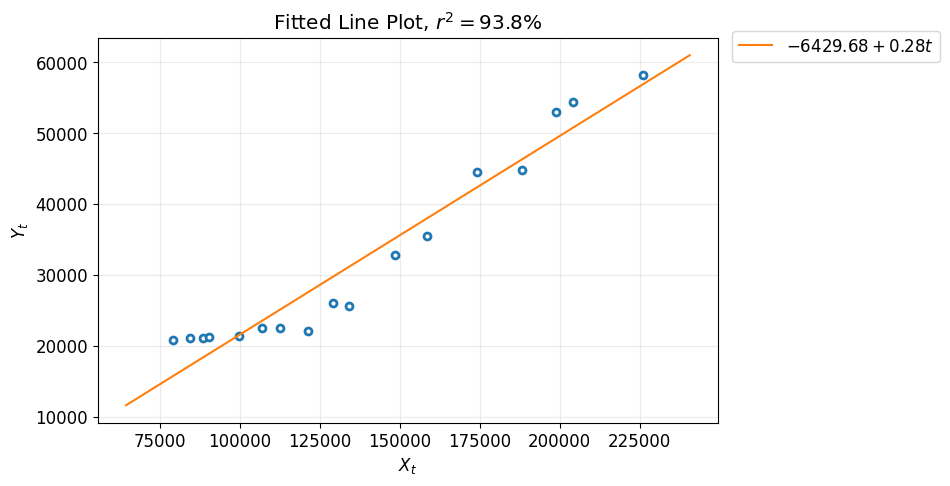

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$Y_t$")
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)



## Log linear regression models

$$
\begin{align*}
  Y_t &= \gamma X_t^{\beta_1} + \epsilon_t \\
  \ln{Y_t} &= \beta_0 + \beta_1 \ln{X_t} + \epsilon_t
\end{align*}
$$

where $\beta_0 = \ln{\gamma}$ and $\beta_1$ is the income elasticity of sales

### Regression Analysis

In [44]:
df_minitab = df[["ln Y_t", "ln X_t"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab

header: ['ln Y_t', 'ln X_t']


,Y,X_1
0,9.945109,11.279348
1,9.954751,11.344516
2,9.957644,11.389761
3,9.962039,11.412444
4,9.973899,11.511199
5,10.021937,11.580886
6,10.022647,11.631684
7,10.005742,11.705584
8,10.165348,11.767714
9,10.150723,11.807035


In [45]:
column_name = ["ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW))", "ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)


Regression Analysis: ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)) versus ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))
The regression equation is
ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)) = -2.567 + 1.093 ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))


Predictor,Coef,SE Coef,t-score,p-value
Constant,-2.5669,1.0544,-2.43,0.0279
ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh)),1.0927,0.0895,12.21,0.0000


s_yxs = 0.1206   R_sq = 90.9%   R-sq(adj) = 90.3%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,2.1703,2.1703,149.189,0.0000
Residual error,15,0.2182,0.0145,,
Total,16,2.3886,,,


Durbin-Watson Statistics = 0.43


In [46]:
MAPE, MAD, MSE = get_accuracy_measures(df_minitab)
print(f"MAPE   {MAPE*100:8.2f}%")
print(f"MAD    {MAD:8.2f}")
print(f"MSE    {MSE:8.2f}")

MAPE       0.96%
MAD        0.10
MSE        0.01


### Fitted line plot

In [47]:
df_fit = df_minitab.copy()
out_dict

{'regress': LinearRegression(),
 'corr_matrix': array([[0.95322711]]),
 'R_sq': 0.9086419216286528,
 'dw_stats': 0.43330511862503895}

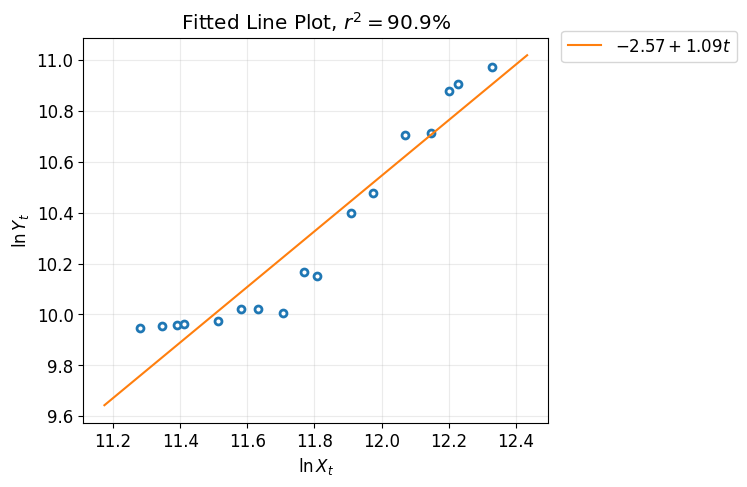

In [48]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$\ln{X_t}$")
ax.set_ylabel(r"$\ln{Y_t}$")

rSq = out_dict["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [49]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_fit) 
k_predictors = 1
dw_stats = out_dict["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.43
  durbin-watson critical values (d_L, d_U): (1.13, 1.38)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.43
  durbin-watson critical values (d_L, d_U): (0.87, 1.1)
  conclusion: null hypotesis rejected



Fred concluded that the correlation between successive errors is positive and large (close to 1)

## Regression with Difference

### Regression Analysis

In [50]:
df_minitab_2 = df[["diff ln Y_t", "diff ln X_t"]]
from_column_names = df_minitab_2.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab_2 = df_minitab_2.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab_2 = df_minitab_2.dropna()
df_minitab_2 = df_minitab_2.reset_index(drop=True)

df_minitab_2


header: ['diff ln Y_t', 'diff ln X_t']


,Y,X_1
0,0.009642,0.065168
1,0.002893,0.045245
2,0.004395,0.022683
3,0.011860,0.098755
4,0.048038,0.069687
5,0.000710,0.050799
6,-0.016906,0.073899
7,0.159606,0.062130
8,-0.014625,0.039322
9,0.248981,0.101210


In [51]:
column_name_2 = ["Change in ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW))", "Change in ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))"]
out_dict_2 = get_minitab_out(df_minitab_2, n_vars=len(column_name_2)-1, 
  new_column=column_name_2, withVIF=False, withCorrMatrix=False, 
  with_intercept=False, is_reg_diff=True)


Regression Analysis: Change in ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)) versus Change in ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))
The regression equation is
Change in ln(Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)) = 1.053 Change in ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh))


Predictor,Coef,SE Coef,t-score,p-value
Constant,0.0000,0.0000,0.00,0.0000
Change in ln(Listrik Yang Didistribusikan Kepada Pelanggan (GWh)),1.0526,0.2836,3.71,0.0021


s_yxs = 0.0793
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,0.0867,0.0867,13.778,0.0021
Residual error,15,0.0944,0.0063,,
Total,16,0.1812,,,


Durbin-Watson Statistics = 2.45


### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [52]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_minitab_2) 
k_predictors = 1
dw_stats = out_dict_2["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 2.45
  durbin-watson critical values (d_L, d_U): (1.1, 1.37)
  conclusion: null hypothesis accepted

significance_lvl: 0.01
  durbin-watson statistics: 2.45
  durbin-watson critical values (d_L, d_U): (0.84, 1.09)
  conclusion: null hypothesis accepted



Because of inclusive in the Durbin-Watson test, we use correlogram plot to check 
the residual autocorrelation

### Correlogram plot

In [53]:
df_correlogram = df_minitab_2.copy()
df_correlogram["e_t"] = df_minitab_2["Y"] - df_minitab_2["hat_Y"]
df_correlogram["t"] = np.arange(1, len(df_correlogram)+1, dtype=int)
df_correlogram

,Y,X_1,hat_Y,e_t,t
0,0.009642,0.065168,0.068595,-0.058953,1
1,0.002893,0.045245,0.047624,-0.044730,2
2,0.004395,0.022683,0.023875,-0.019480,3
3,0.011860,0.098755,0.103947,-0.092087,4
4,0.048038,0.069687,0.073351,-0.025313,5
5,0.000710,0.050799,0.053469,-0.052759,6
6,-0.016906,0.073899,0.077785,-0.094690,7
7,0.159606,0.062130,0.065397,0.094209,8
8,-0.014625,0.039322,0.041389,-0.056014,9
9,0.248981,0.101210,0.106532,0.142450,10


In [54]:
num_of_rk = 10

df_acorr_analysis = get_correlogram(df_correlogram, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.251794,-1.007176,1.217285,-0.532862,0.532862
1,2,0.573959,2.162804,7.994102,-0.565638,0.565638
2,3,-0.108240,-0.324001,8.253652,-0.712056,0.712056
3,4,0.184628,0.549070,9.071752,-0.716713,0.716713
4,5,-0.202454,-0.591050,10.144887,-0.730092,0.730092
5,6,-0.060241,-0.172150,10.249401,-0.745863,0.745863
6,7,-0.149308,-0.425889,10.962773,-0.747243,0.747243
7,8,-0.241053,-0.679919,13.054604,-0.755666,0.755666
8,9,-0.039438,-0.108159,13.118596,-0.777193,0.777193
9,10,-0.141134,-0.386777,14.074700,-0.777761,0.777761


C:\Users\User\AppData\Local\Temp\ipykernel_18336\2725728046.py:13: MatplotlibDeprecationWarning: MarkerStyle(None) is deprecated since 3.6; support will be removed two minor releases later.  Use MarkerStyle('') to construct an empty MarkerStyle.
  stem_handler[0].set_marker(None)


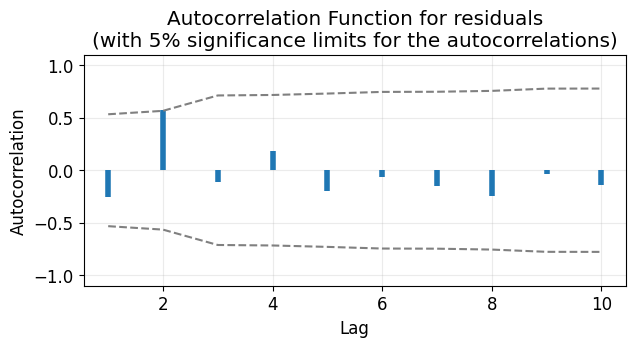

In [55]:
plot_autocorr_func(df_acorr_analysis, title=r"residuals")

The correlogram plot above shows that the autocorrelation of the residuals are well within their two standard error limits (the dashed lines in the figure)

### Forecasting from regression with differences

$$
  \begin{align*}
    \hat{Y}'_t 
      &= b_1 X'_t \\
    \ln{\hat{Y}_t} - \ln{\hat{Y}_{t-1}}
      &= b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \\
    \ln{\hat{Y}_t}
      &= \ln{\hat{Y}_{t-1}} + b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \\
    \hat{Y}_t
      &= \exp\left\{ \ln{\hat{Y}_{t-1}} + b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \right\}
  \end{align*}
$$

In [56]:
X_t = df["Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"]
Y_t = df["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)"]
t_forecast = 17
hat_Y_tM1_forecast = Y_t.iloc[(t_forecast-1) - 1]
X_tM1_forecast = X_t.iloc[(t_forecast - 1) - 1]
X_t_forecast = 241405.6 
b1_estimate = out_dict_2["regress"].coef_[0]
# print(b1_estimate)
hat_Y_t_forecast = np.exp(
  np.log(hat_Y_tM1_forecast) + b1_estimate * (
    np.log(X_t_forecast) - np.log(X_tM1_forecast)))

print(f"${hat_Y_t_forecast:,.0f} MW")

$64,866 MW


In [57]:
df_forecast = pd.DataFrame()
df_forecast["t"] = np.arange(len(df))
df_forecast["Y_t"] = df["Kapasitas Terpasang PLN menurut Jenis Pembangkit Listrik (MW)"]
df_forecast["X_t"] = df["Listrik Yang Didistribusikan Kepada Pelanggan (GWh)"]

df_forecast["Y_tM1"] = df_forecast["Y_t"].shift(1)
df_forecast["X_tM1"] = df_forecast["X_t"].shift(1)
df_forecast["hat{Y}"] = np.exp(
  np.log(df_forecast["Y_tM1"]) + b1_estimate*(
    np.log(df_forecast["X_t"]) - np.log(df_forecast["X_tM1"])))
df_forecast

,t,Y_t,X_t,Y_tM1,X_tM1,hat{Y}
0,0,20850.00,79169.63,NaN,NaN,NaN
1,1,21052.00,84500.80,20850.00,79169.63,22330.389803
2,2,21113.00,88411.85,21052.00,84500.80,22078.834049
3,3,21206.00,90440.18,21113.00,88411.85,21623.142905
4,4,21459.00,99827.50,21206.00,90440.18,23528.946875
5,5,22515.00,107032.30,21459.00,99827.50,23092.202753
6,6,22531.00,112609.85,22515.00,107032.30,23751.628819
7,7,22153.30,121246.84,22531.00,112609.85,24353.529917
8,8,25986.90,129018.85,22153.30,121246.84,23650.473110
9,9,25609.60,134193.15,25986.90,129018.85,27085.042403


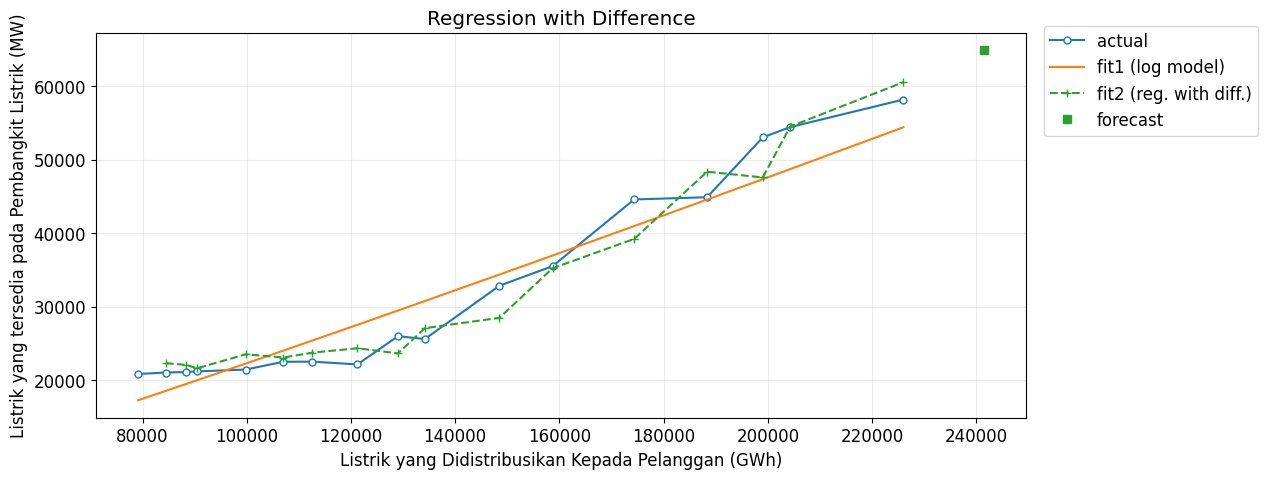

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_forecast["X_t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

X_t = df_forecast["X_t"]
regress1 = out_dict["regress"]
b0 = regress1.intercept_
b1 = regress1.coef_
Y_t_log_model = np.exp(b0) * (X_t**b1)
ax.plot(X_t, Y_t_log_model, linestyle="-",
  label="fit1 (log model)")

forecast_key = "hat{Y}"
fit2_plot = ax.plot(X_t, df_forecast[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label="fit2 (reg. with diff.)")

color = fit2_plot[0]._color
ax.plot([X_t_forecast], [hat_Y_t_forecast], marker='s', markersize=6, 
  linestyle="None", label="forecast", color=color)

ax.set_xlabel("Listrik yang Didistribusikan Kepada Pelanggan (GWh)")
ax.set_ylabel("Listrik yang tersedia pada Pembangkit Listrik (MW)")
ax.set_title("Regression with Difference")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)